
## Семинар 4. Модели экспоненциального сглаживания. Порядок построения и валидации модели.



In [1]:
from sktime.datasets import load_uschange
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np


from sktime.forecasting.all import temporal_train_test_split
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

from sktime.forecasting.base import ForecastingHorizon

from sktime.datasets import load_macroeconomic, load_airline

from sktime.forecasting.model_selection import SlidingWindowSplitter, ExpandingWindowSplitter, ForecastingGridSearchCV
from sktime.transformations.series.boxcox import BoxCoxTransformer

from sktime.utils.plotting import plot_correlations


plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,5)


### Общий алгоритм

Временные ряды отличаются некоторой спецификой. Основной проблемой при работе с такими данными является наличие утечек. На всех этапах работы с временными рядами обращайте внимание на потенциальные места, провоцирующие утечки. Ниже я собрал в одну схему некоторую последовательность действий, которые обычно следует совершить при работе с временными рядами. Разберём его по шагам.

![algorithm](images/sem_4_algorithm.png)


/var/folders/cp/4bl3kvm10tl3r81sxqkgg1q00000gn/T/ipykernel_58185/3109595427.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  y = pd.read_csv('./data/sem_4/hour_online.csv', index_col=['Time'], parse_dates=['Time']).Users


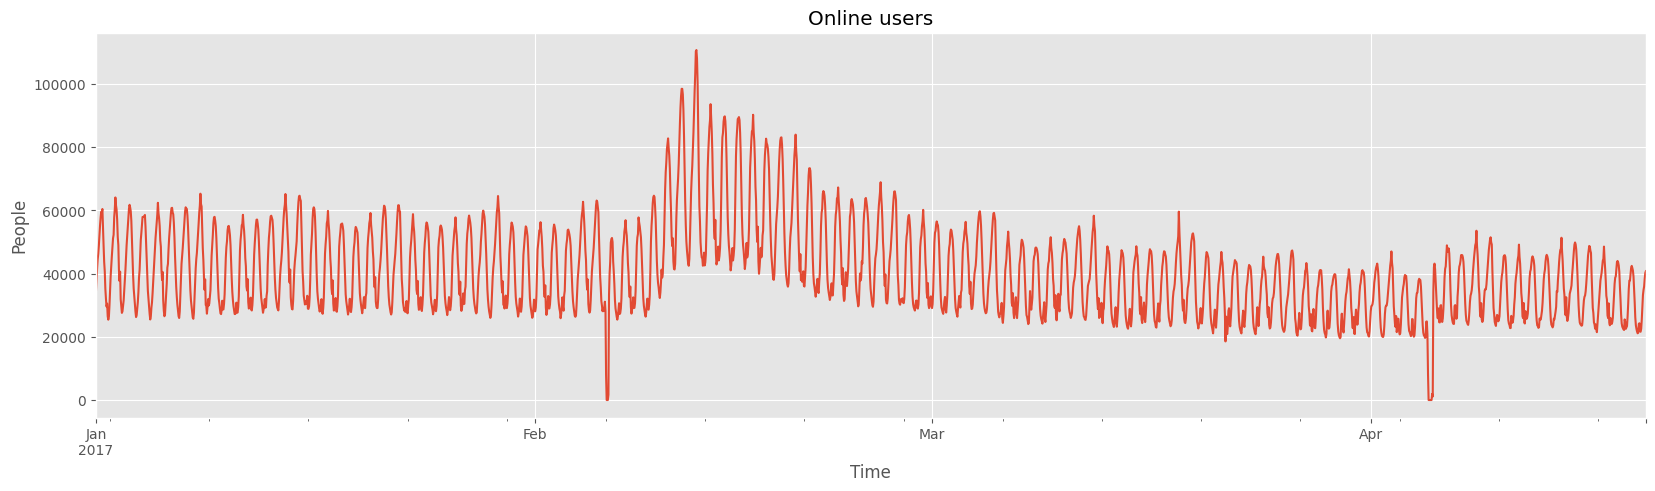

In [2]:
y = pd.read_csv('./data/sem_4/hour_online.csv', index_col=['Time'], parse_dates=['Time']).Users

# Вот этот шаг был неочевиден. С обычным datetime индексом всё ломалось по очевидной недоделке. Думаю, это скоро допилят
y.index = pd.PeriodIndex(y.index, freq="H")
y = y.astype(np.float64)

# y.diff().dropna().plot()
y.plot()
plt.title('Online users')
plt.ylabel('People');



In [3]:
test_size = 7*24

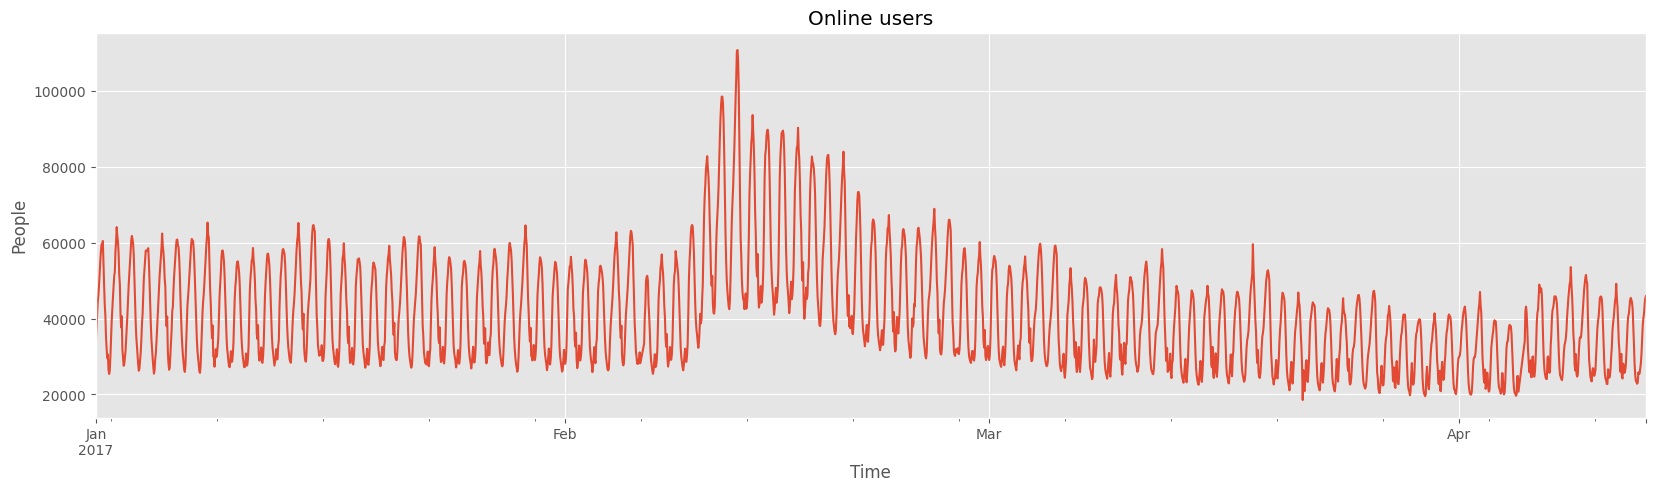

In [4]:
# Убираем выбросы и интерполируем
y[y<10000] = np.nan
y = y.interpolate()

y_train, y_test = temporal_train_test_split(y, test_size=test_size)
y_train.plot()


plt.title('Online users')
plt.ylabel('People');


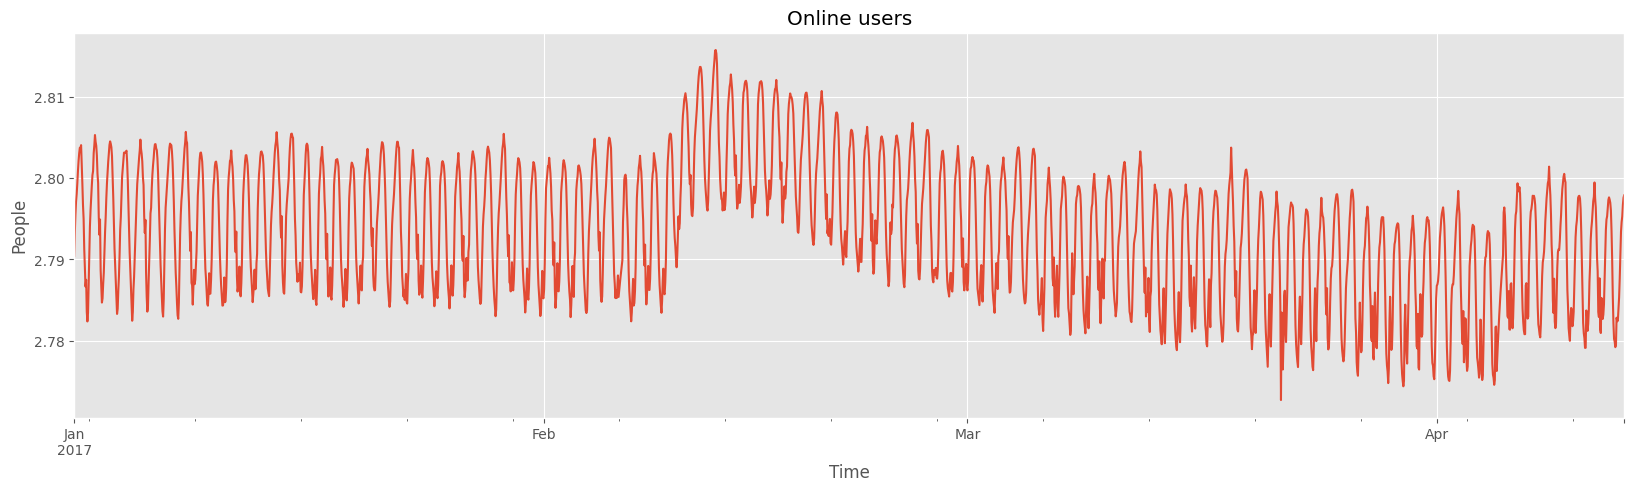

In [5]:

transformer = BoxCoxTransformer()
y_train_hat = transformer.fit_transform(y_train)


y_train_hat.plot()

plt.title('Online users')
plt.ylabel('People');


In [6]:
transformer.lambda_

-0.3489753582021295

In [7]:


fh = ForecastingHorizon(list(range(1, test_size+1)))

forecaster = AutoETS(sp=24)
param_grid = {
    'error': ['add', 'mul'],
    'trend': [None, 'add'],
    'seasonal': ['mul'],
}

In [8]:
y_train_hat.shape

(2457,)

In [9]:
cv = SlidingWindowSplitter(

    window_length=300,
    step_length=50,
    fh=fh)
gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv,
    verbose=1,
    n_jobs=-1
    )
gscv.fit(y_train_hat);

/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/sktime/forecasting/model_selection/_tune.py:198: UserWarning: in ForecastingGridSearchCV, n_jobs and pre_dispatch parameters are deprecated and will be removed in 0.26.0. Please use n_jobs and pre_dispatch directly in the backend_params argument instead.
  warn(


Fitting 40 folds for each of 4 candidates, totalling 160 fits
Fitting 40 folds for each of 18 candidates, totalling 720 fits


/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:455: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:455: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:455: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Users/mszekhov/Desktop/current_projects/hse_ts_c

In [10]:
# Assuming gscv is your fitted ForecastingGridSearchCV object
cv_results = gscv.cv_results_

# Convert to DataFrame for easier viewing and analysis
results_df = pd.DataFrame(cv_results)

params_df = pd.json_normalize(results_df['params'])
# Concatenate the new parameters DataFrame with the original results minus the 'params' column
results_df_expanded = pd.concat([results_df.drop(columns=['params']), params_df], axis=1)

# Sort the DataFrame by rank of the test MAPE
results_df_sorted = results_df_expanded.sort_values(by='rank_test_MeanAbsolutePercentageError')

results_df_sorted.columns = [
    "Mean Test MAPE",
    "Mean Fit Time",
    "Mean Prediction Time",
    "Rank",
    "Error",
    "Seasonal",
    "Trend"
]

# Display the sorted DataFrame for comparison
results_df_sorted


,Mean Test MAPE,Mean Fit Time,Mean Prediction Time,Rank,Error,Seasonal,Trend
2,0.001079,0.122599,0.004113,1.0,mul,mul,None
0,0.001079,0.096779,0.004226,2.0,add,mul,None
3,0.001246,0.162920,0.004566,3.0,mul,mul,add
1,0.001248,0.122540,0.004252,4.0,add,mul,add


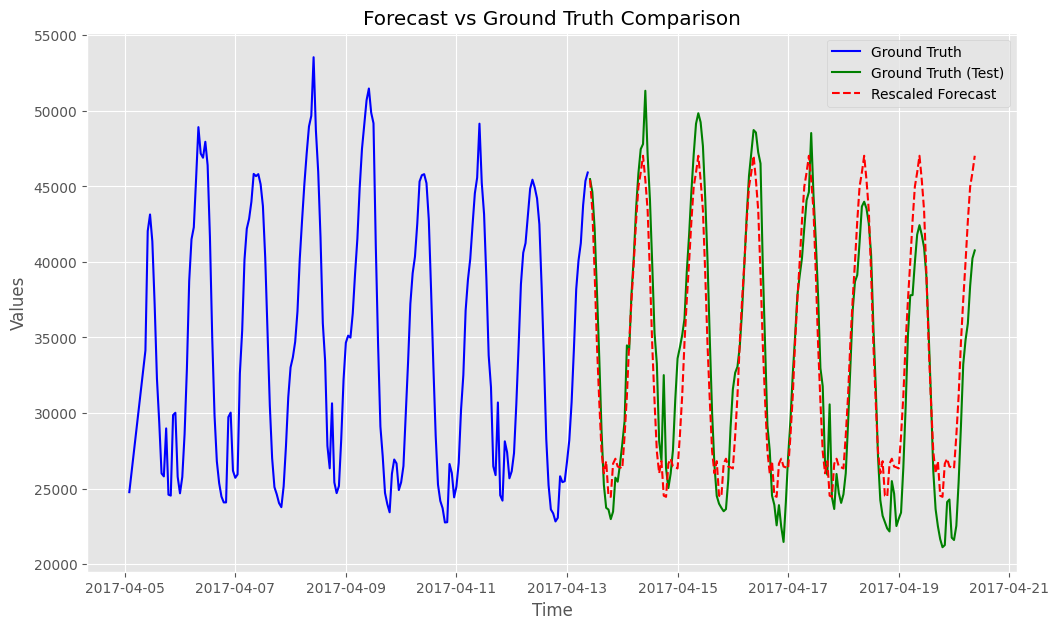

In [11]:
# Step 1: Identify the best forecaster
# (Assuming `gscv` is your fitted ForecastingGridSearchCV object)
best_forecaster = gscv.best_forecaster_

best_forecaster.fit(y_train_hat)

# Step 2: Generate forecast using the best forecaster
# Assuming `fh` is your forecasting horizon
forecast = best_forecaster.predict(fh)

# Step 3: Rescale forecast (if your transformer supports inverse_transform)
rescaled_forecast = transformer.inverse_transform(forecast)
# Selecting the last 100 observations from y_train
y_train_last = y_train.iloc[-200:]

# Assuming y_test is your actual test data
# (No need to adjust y_test, assuming it matches the forecast horizon)

plt.figure(figsize=(12, 7))

# Plotting the last 100 observations of y_train
plt.plot(y_train_last.index.to_timestamp(), y_train_last, label='Ground Truth', color='blue')

# Plotting the actual test data
plt.plot(y_test.index.to_timestamp(), y_test, label='Ground Truth (Test)', color='green')

# Plotting the rescaled forecast
plt.plot(forecast.index.to_timestamp(), rescaled_forecast, label='Rescaled Forecast', linestyle='--', color='red')

plt.legend()
plt.title('Forecast vs Ground Truth Comparison')
plt.xlabel('Time')
plt.ylabel('Values')
plt.show()


In [12]:
forecast_standard = rescaled_forecast.copy()

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='Users'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

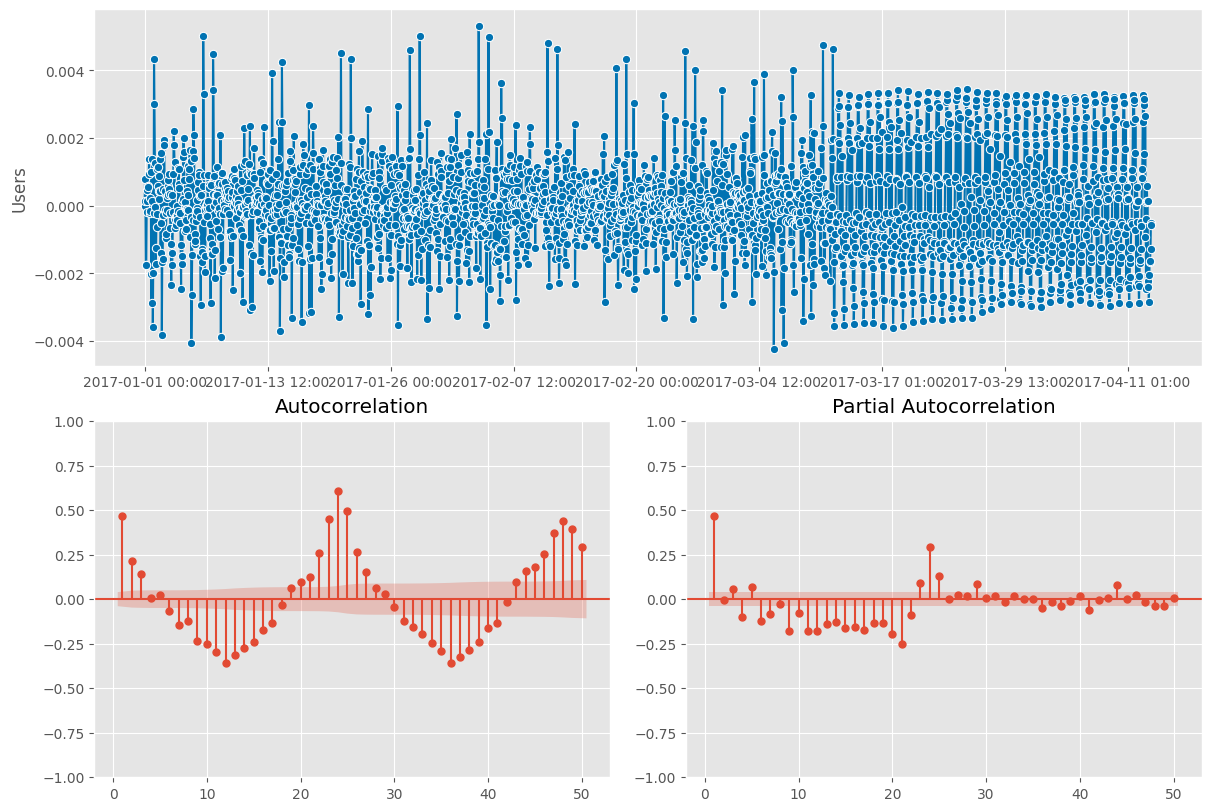

In [13]:

residuals = best_forecaster.predict_residuals()
plot_correlations(residuals, lags=50, zero_lag=False)

In [14]:
from statsmodels.tsa.stattools import acf
from scipy.stats import chi2


n_lags = 20
n_obs = len(residuals)
autocorrelations = acf(residuals, nlags=n_lags)[1:]
box_pirece_statistics = n_obs * (autocorrelations**2).sum()
box_pirece_statistics
box_pirece_pval = 1 - chi2.cdf(box_pirece_statistics, df=n_lags)

f"Box-Pierce test. Statistics: {box_pirece_statistics}, p-value: {box_pirece_pval}"

'Box-Pierce test. Statistics: 2324.9549590848133, p-value: 0.0'

In [15]:
denominators = n_obs - np.arange(1, n_lags+1)

In [16]:
autocorrelations

array([ 0.46696865,  0.21439421,  0.14192052,  0.00638854,  0.02449706,
       -0.06500768, -0.14411244, -0.12409038, -0.23594925, -0.24821387,
       -0.29394403, -0.35785412, -0.31081721, -0.27332441, -0.23944795,
       -0.17027595, -0.13368353, -0.03314498,  0.06356306,  0.09305956])

Box-pierce test

In [17]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(residuals, boxpierce=True, lags=n_lags)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,536.427187,1.129003e-118,535.772742,1.567005e-118
2,649.546898,8.967744e-142,648.708443,1.363802e-141
3,699.135231,3.232615e-151,698.195946,5.166853e-151
4,699.235755,5.101748e-150,698.296225,8.149917e-150
5,700.714424,3.441791e-149,699.770685,5.506041e-149
6,711.131594,2.415401e-150,710.153963,3.927240e-150
7,762.346994,2.469076e-160,761.181914,4.404252e-160
8,800.335404,1.742649e-167,799.015837,3.354330e-167
9,937.736267,4.564962e-196,935.802056,1.192104e-195
10,1089.854690,8.117047e-228,1087.178135,3.064367e-227


In [18]:
class DiffTransformer:
    def __init__(self, lags=1):
        self.lags = lags

    def fit_transform(self, x:pd.Series):
        
        return (x - x.shift(self.lags)).dropna() + 1

    def inverse_transform(self, x:pd.Series, init_sequence: list):
    
        assert len(init_sequence) == self.lags

        x = x - 1
        
        for value in x.values:
            init_sequence.append(value + init_sequence[-self.lags])

        return init_sequence[self.lags:]

In [19]:
diff_transformer = DiffTransformer(lags=24)

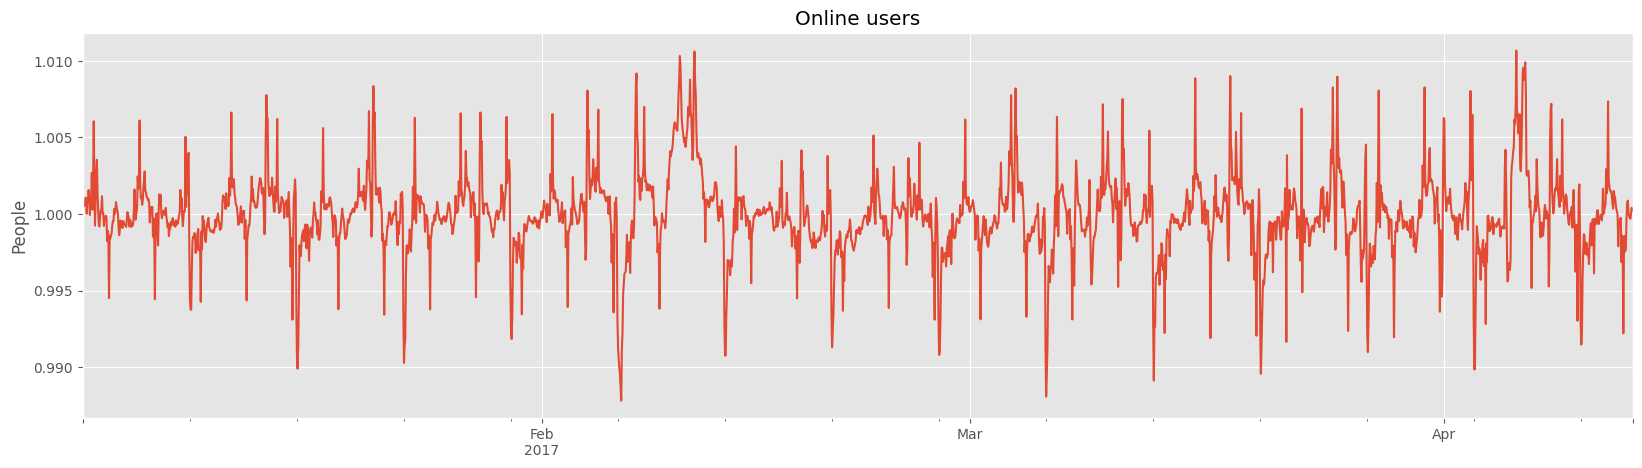

In [20]:
y_train_hat_diff = diff_transformer.fit_transform(y_train_hat)

y_train_hat_diff.plot()

plt.title('Online users')
plt.ylabel('People');

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='Users'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

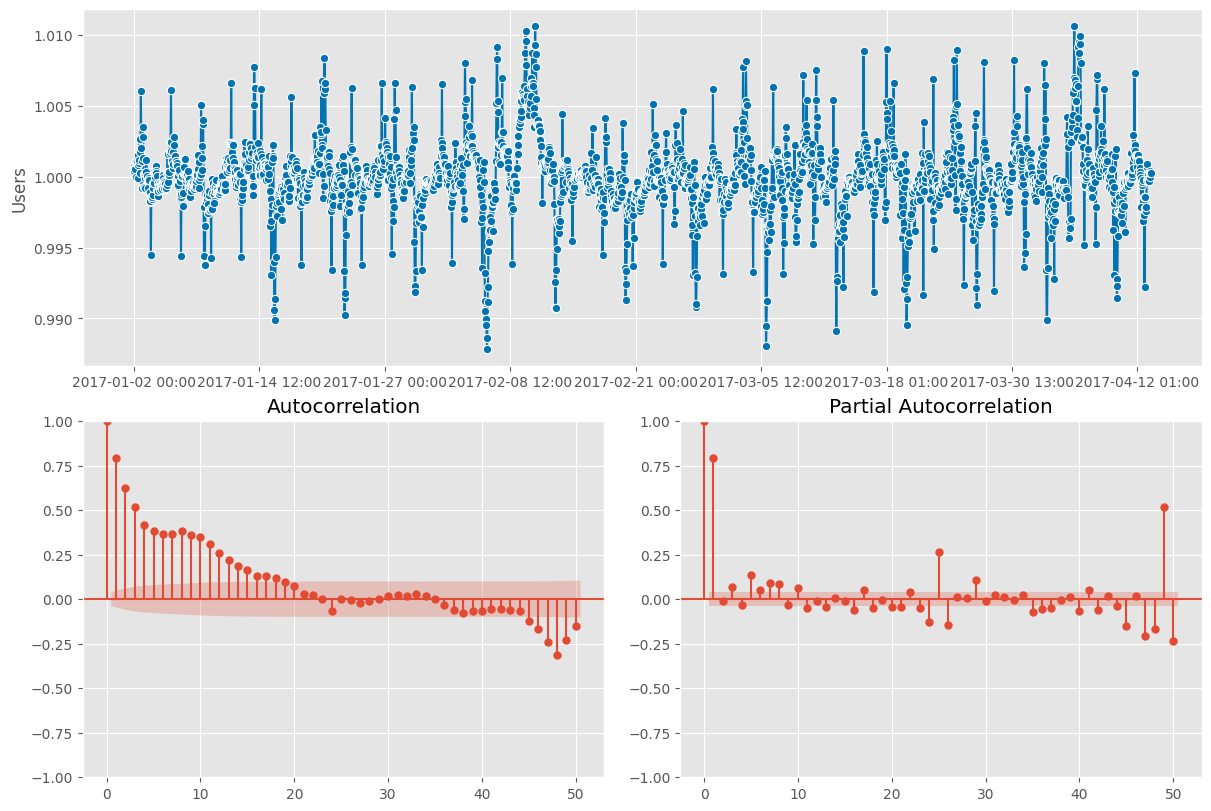

In [21]:
plot_correlations(y_train_hat_diff, lags=50)

In [22]:

forecaster = AutoETS(sp=24)
param_grid = {
    'error': ['add', 'mul'],
    'trend': [None, 'add', 'mul'],
    'seasonal': [None, 'add', 'mul'],
}

cv = SlidingWindowSplitter(

    window_length=300,
    step_length=50,
    fh=fh)
gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv,
    verbose=1,
    n_jobs=-1
    )


gscv.fit(y_train_hat_diff);

/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/sktime/forecasting/model_selection/_tune.py:198: UserWarning: in ForecastingGridSearchCV, n_jobs and pre_dispatch parameters are deprecated and will be removed in 0.26.0. Please use n_jobs and pre_dispatch directly in the backend_params argument instead.
  warn(
/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:455: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/sktime/performance_metrics/forecasting/_classes.py:455: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/Users/mszekho

In [23]:
# Assuming gscv is your fitted ForecastingGridSearchCV object
cv_results = gscv.cv_results_

# Convert to DataFrame for easier viewing and analysis
results_df = pd.DataFrame(cv_results)

params_df = pd.json_normalize(results_df['params'])
# Concatenate the new parameters DataFrame with the original results minus the 'params' column
results_df_expanded = pd.concat([results_df.drop(columns=['params']), params_df], axis=1)

# Sort the DataFrame by rank of the test MAPE
results_df_sorted = results_df_expanded.sort_values(by='rank_test_MeanAbsolutePercentageError')

results_df_sorted.columns = [
    "Mean Test MAPE",
    "Mean Fit Time",
    "Mean Prediction Time",
    "Rank",
    "Error",
    "Seasonal",
    "Trend"
]

# Display the sorted DataFrame for comparison
results_df_sorted


,Mean Test MAPE,Mean Fit Time,Mean Prediction Time,Rank,Error,Seasonal,Trend
6,0.002897,0.114769,0.006606,1.0,add,mul,None
15,0.002898,0.120477,0.005081,2.0,mul,mul,None
3,0.002898,0.117358,0.008309,3.0,add,add,None
12,0.002899,0.131884,0.005669,4.0,mul,add,None
0,0.002906,0.007711,0.005165,5.0,add,None,None
9,0.002906,0.006131,0.004997,6.0,mul,None,None
7,0.003357,0.176998,0.005727,7.0,add,mul,add
4,0.003358,0.179119,0.007283,8.0,add,add,add
16,0.003359,0.171250,0.005235,9.0,mul,mul,add
8,0.003359,0.212182,0.006262,10.0,add,mul,mul


In [24]:
results_df_expanded

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,rank_test_MeanAbsolutePercentageError,error,seasonal,trend
0,0.002906,0.007711,0.005165,5.0,add,None,None
1,0.003366,0.015974,0.006010,13.0,add,None,add
2,0.003369,0.019617,0.007951,15.0,add,None,mul
3,0.002898,0.117358,0.008309,3.0,add,add,None
4,0.003358,0.179119,0.007283,8.0,add,add,add
5,0.003364,0.207999,0.007455,12.0,add,add,mul
6,0.002897,0.114769,0.006606,1.0,add,mul,None
7,0.003357,0.176998,0.005727,7.0,add,mul,add
8,0.003359,0.212182,0.006262,10.0,add,mul,mul
9,0.002906,0.006131,0.004997,6.0,mul,None,None


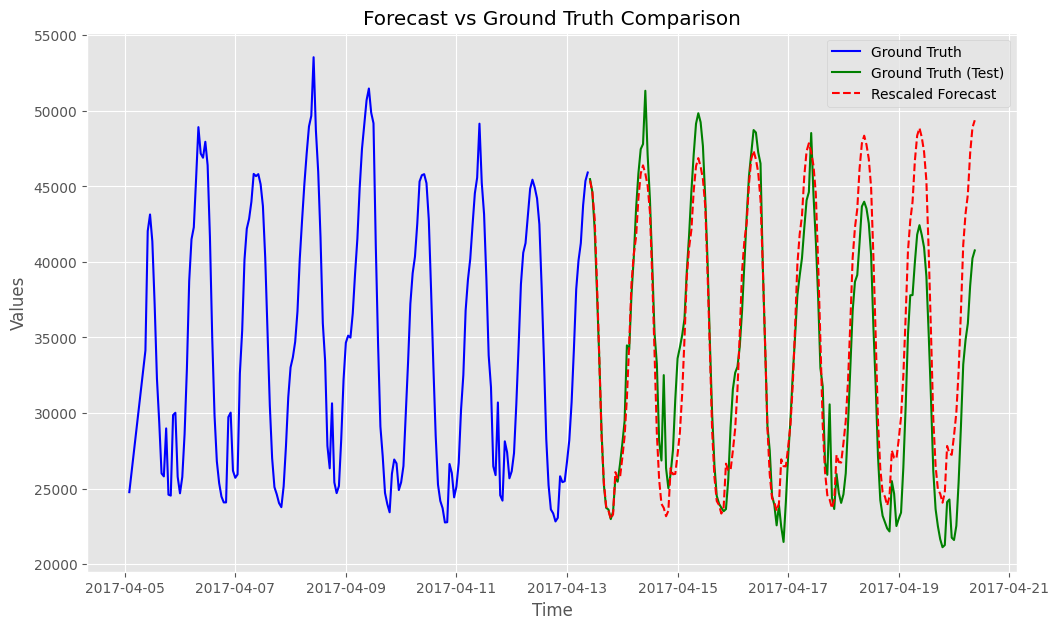

In [25]:
# Step 1: Identify the best forecaster
# (Assuming `gscv` is your fitted ForecastingGridSearchCV object)
best_forecaster = gscv.best_forecaster_

best_forecaster.fit(y_train_hat_diff)

# Step 2: Generate forecast using the best forecaster
# Assuming `fh` is your forecasting horizon
forecast = best_forecaster.predict(fh)

trended_forecast = diff_transformer.inverse_transform(forecast, y_train_hat.tail(24).to_list())
trended_forecast = pd.Series(trended_forecast, index = forecast.index)
# Step 3: Rescale forecast (if your transformer supports inverse_transform)
rescaled_forecast = transformer.inverse_transform(trended_forecast)
# Selecting the last 100 observations from y_train
y_train_last = y_train.iloc[-200:]

# Assuming y_test is your actual test data
# (No need to adjust y_test, assuming it matches the forecast horizon)

plt.figure(figsize=(12, 7))

# Plotting the last 100 observations of y_train
plt.plot(y_train_last.index.to_timestamp(), y_train_last, label='Ground Truth', color='blue')

# Plotting the actual test data
plt.plot(y_test.index.to_timestamp(), y_test, label='Ground Truth (Test)', color='green')

# Plotting the rescaled forecast
plt.plot(forecast.index.to_timestamp(), rescaled_forecast, label='Rescaled Forecast', linestyle='--', color='red')

plt.legend()
plt.title('Forecast vs Ground Truth Comparison')
plt.xlabel('Time')
plt.ylabel('Values')
plt.show()


In [26]:
forecast_diff = rescaled_forecast.copy()

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='Users'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

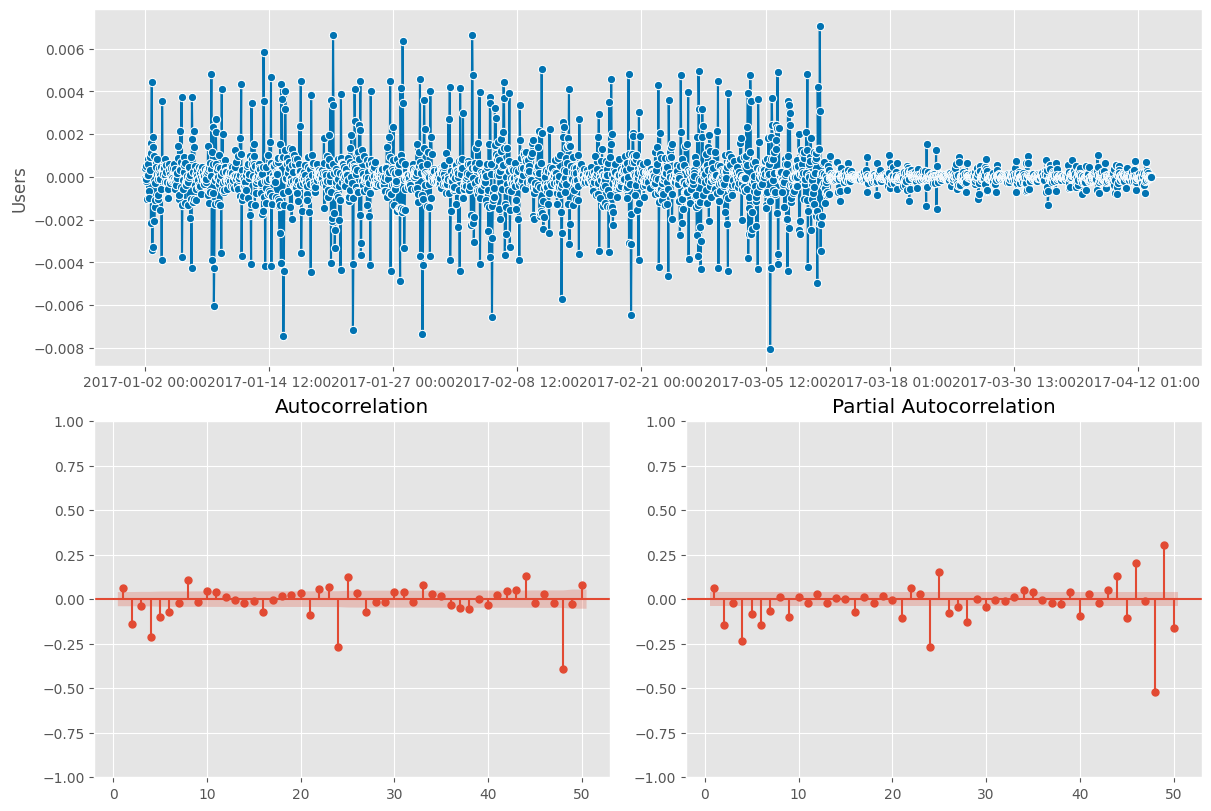

In [27]:

residuals = best_forecaster.predict_residuals()
plot_correlations(residuals, lags=50, zero_lag=False)

In [28]:
mean_absolute_percentage_error(y_true=y_test, y_pred=forecast_standard)


0.08471897527938105

In [29]:

mean_absolute_percentage_error(y_true=y_test, y_pred=forecast_diff)

0.0871810052708368

In [32]:
from dieboldmariano import dm_test

dm_test(y_test.to_list(), forecast_standard.to_list(), forecast_diff.to_list(), one_sided=True)

(-2.497481812636066, 0.006738080250384743)

In [31]:
forecast_diff

2017-04-13 10:00    45383.659853
2017-04-13 11:00    44626.947051
2017-04-13 12:00    42896.605957
2017-04-13 13:00    38644.865600
2017-04-13 14:00    33752.706331
                        ...     
2017-04-20 05:00    43193.224253
2017-04-20 06:00    44458.860222
2017-04-20 07:00    47201.476281
2017-04-20 08:00    48891.366844
2017-04-20 09:00    49380.730551
Freq: H, Length: 168, dtype: float64

In [31]:
y_test

Time
2017-04-13 10:00    45481.0
2017-04-13 11:00    44630.0
2017-04-13 12:00    42197.0
2017-04-13 13:00    38038.0
2017-04-13 14:00    33675.0
                     ...   
2017-04-20 05:00    34833.0
2017-04-20 06:00    35932.0
2017-04-20 07:00    38418.0
2017-04-20 08:00    40238.0
2017-04-20 09:00    40763.0
Freq: H, Name: Users, Length: 168, dtype: float64

1) Эксплоративный анализ. Подробно об этом мы уже поговорили на предыдущих семинарах и сейчас останавливаться не будем. Основная идея: необходимо заметить как можно больше паттернов в ряде, чтобы проще было подбирать модель или фичи.

2) Разбиение на трейн и тест. Эту часть мы с вами также довольно подробно разобрали. Важные особенности, которые следует держать в голове:

* Тест идёт строго после трейна, иначе будет утечка. 
* Если нормируете или как-либо ещё предобрабатываете данные, делайте это только на трейне. Иначе за счёт информации о тесте в нормировке произойдёт утечка.


3) Помимо привычной вам предобработки из машинного обучения, во временных рядах также часто используются преобразования, сводящие ряд к стационарному. Стационарные ряды нам интересны по вполне очевидной причине: чем меньше меняются характеристики ряда по времени, тем проще его прогнозировать. В контексте ETS-моделей этот вопрос не сильно важен. ETS-модели сами по себе моделируют нестационарные ряды с трендами. Однако в контексте ARMA-моделей это будет ключевым вопросом.

* Сделать ряд стационарным по матожиданию можно всегда. Для этого необходимо просто несколько раз последовательно взять разности от него. Количество раз, необходимых для тренд-стационарности ряда, называется порядком интеграции (Integration order) и обычно обозначается как I(k), где k -- порядок интеграции. Про тестирование ряда на стационарность также поговорим через пару семинаров.

* Со стационарностью по дисперсии всё сложнее. Она бывает сложной формы и не всегда можно подобрать такое преобразование, которое её сгладит. В большинстве случаев это просто игнорируют, либо учитывают уже в самой модели (например, мультипликативная сезонность)

Ниже приведён пример обработки ряда с авиаперевозками. Мы видим, что дисперсия зависит от экспоненциального тренда. Попробуем сгладить её логарифмом.

Преобразование Бокса-Кокса является способом автоматизировать стабилизацию дисперсии. Оно устроено следующим образом:

 $$\frac{y^{\lambda}-1}{\lambda}, \lambda \neq 0 \text { or } \ln (y), \lambda=0$$

Легко показать, что в пределе по $\lambda$ дробь стремится к логарифму. С помощью метода максимального правдоподобия можно найти оценку оптимального параметра  $\lambda$.

Давайте далее возьмём какие-нибудь данные и будем на них сразу практиковаться. У нас будут довольно простые данные, количество игроков в час в одной мобильной онлайн-игре. В наших данных нет особых трендов и монотонных нестационарностей по дисперсии, поэтому преобразовывать ничего не будем. Единственное, что сделаем -- подвинем трейн немного вверх, чтобы мультипликативные модели не сбоили. Далее просто разобьём на трейн и тест.


4) Окей. Мы имеем предобработанные трейн и набор инструкций, чтобы сделать обратные преобразования над прогнозами. Собственно, пора переходить к построению модели. Необходимо выбрать подходящую архитектуру и подобрать на ней гиперпараметры для наилучшего качества прогнозов. Существует ряд автоматических алгоритмов для подбора гиперпараметров. Например, AutoETS и AutoARIMA. Однако большинство из них (за исключением AutoARIMA) представляют из себя обычную кросс-валидацию, зашитую в удобный (или нет) пайплайн.

    На практике обычно руками подобрать модель может быть более эффективно. Например, AutoARIMA я обычно переигрываю при построении на глаз. Поэтому полагаться на них особо не стоит и лучше самостоятельно провести кросс-валидацию. 





5) Допустим вы выбрали самостоятельно делать кросс-валидацию. Для начала следует, полагаясь на здравый смысл и статистические тесты (будет позже), выбрать модели-кандидаты. То есть, построить сетку для кросс-валидации. Посмотрим на данные. Явных трендов почти нет. Значит ограничимся моделями без тренда или с аддитивным трендом. Далее, в районе февраля видим повышение онлайна. Можно заметить, что сезонные колебания в это время были выше. Значит, можно попробовать модели с мультипликативной сезонностью и мультипликативной ошибкой.




6) Наша сетка готова. Но про саму кросс-валидацию мы ещё не говорили. А она имеет свои особенности. Во временных рядах нельзя шаффлить (есть аргументы, что можно, но здесь я ретроград) и нельзя ставить трейн после теста хронологически. Значит, учтём эти ограничения. Всего выделяют два основных метода: расширяющегося окна (Expanding window) и скользящего окна (Sliding window). Вообще их больше, но эти два наиболее часто используются. Об остальных можно почитать, например, в [статье](https://arxiv.org/pdf/1905.11744.pdf).

### Метод скользящего окна

Может быть полезен, если данные сильно нестационарны. Поможет не смещать сильно модель относительно далёких данных

![](images/sem_4_crossval_1.jpg)


### Метод расширяющегося окна

Учитывает максимум данных и будет полезен, когда данные более-менее стационарны

![](images/sem_4_crossval_2.jpg)

### Общая картинка

![](images/sem_4_crossval_3.png)

In [110]:
gscv.best_params_

{'error': 'mul', 'seasonal': 'mul', 'trend': None}

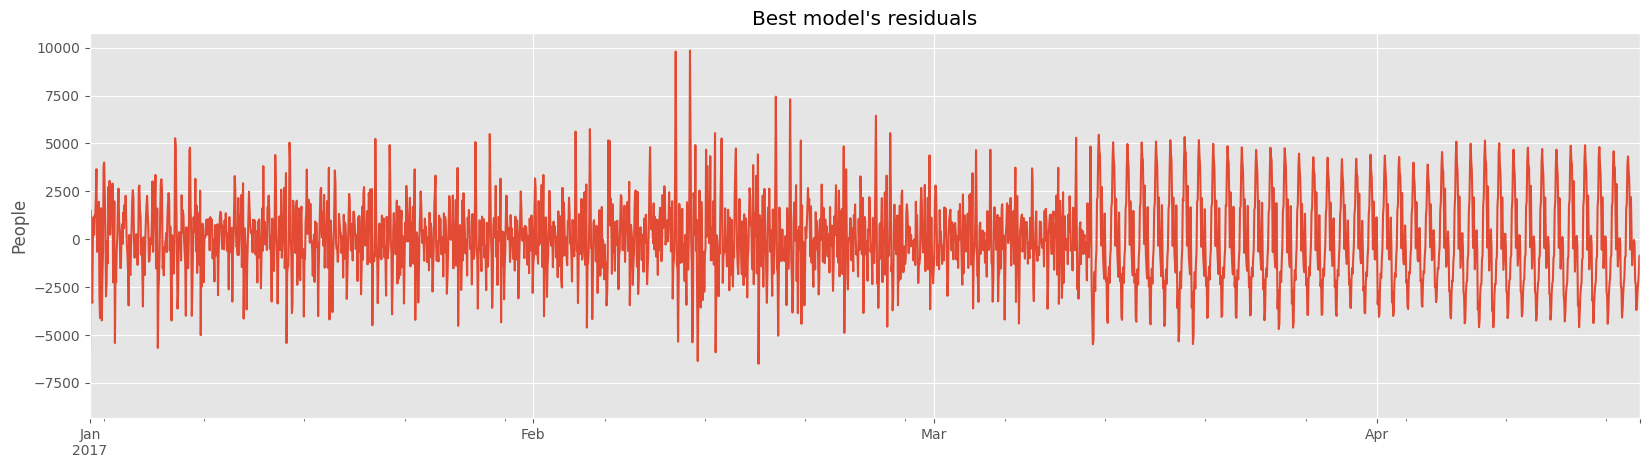

In [146]:
resid = gscv.predict_residuals()

resid.plot()
plt.title('Best model\'s residuals')
plt.ylabel('People');

(<Figure size 1200x800 with 3 Axes>,
 array([<AxesSubplot: >,
        <AxesSubplot: title={'center': 'Autocorrelation'}>,
        <AxesSubplot: title={'center': 'Partial Autocorrelation'}>],
       dtype=object))

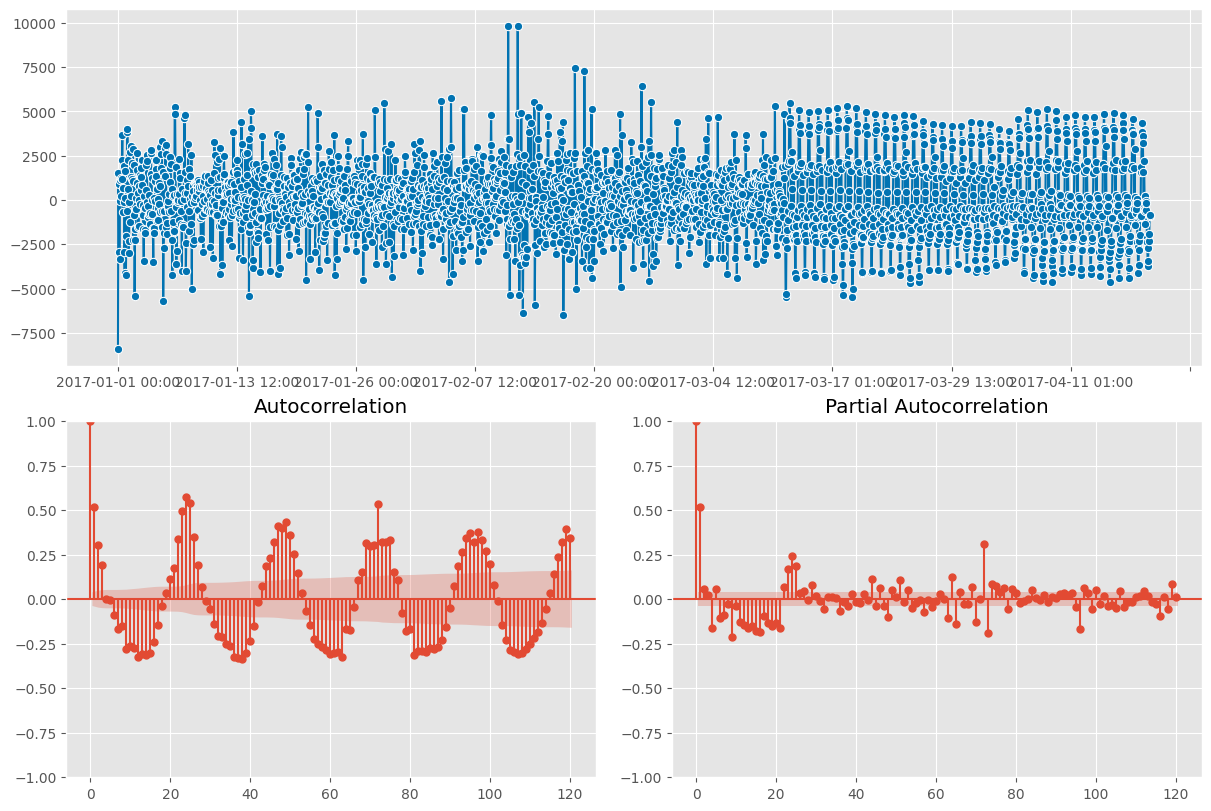

In [147]:
plot_correlations(resid, lags = 24*5)

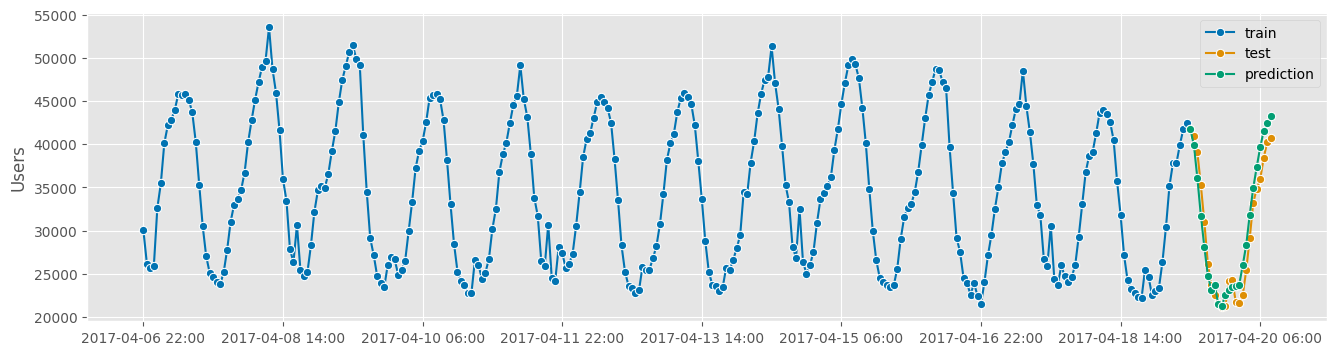

In [113]:
y_pred = gscv.predict(fh)
plot_series(y_train.tail(300), y_test, y_pred,  labels=['train', 'test', 'prediction']);

print(f'Forecast error: {mean_absolute_percentage_error(y_test, y_pred)}')